In [1]:
import pandas as pd
from deep_translator import GoogleTranslator
from langdetect import detect
from tqdm import tqdm
import matplotlib.pyplot as plt
import re

In [2]:
data = pd.read_csv('goodreads_scraper/books.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9745 entries, 0 to 9744
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   book_id               9745 non-null   int64  
 1   book_title            9745 non-null   object 
 2   isbn                  9745 non-null   object 
 3   author                9745 non-null   object 
 4   num_pages             9647 non-null   float64
 5   description           9723 non-null   object 
 6   cover_image_uri       9745 non-null   object 
 7   series_length         5064 non-null   float64
 8   year_first_published  9734 non-null   float64
 9   average_rating        9745 non-null   float64
 10  rating_distribution   9745 non-null   object 
 11  tags                  9745 non-null   object 
dtypes: float64(4), int64(1), object(7)
memory usage: 913.7+ KB


In [4]:
data['language'] = data['description'].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')
language_counts = data['language'].value_counts()

In [5]:
print("Books with non-English description: " + str(len(data[data['language'] != 'en'])))
print("Number of boxed sets: " + str(len(data[data['book_title'].str.contains('boxed', case=False, na=False)]) + len(data[data['book_title'].str.contains('box set', case=False, na=False)].index)))
print("Number of collections: " + str(len(data[data['book_title'].str.contains('collection', case=False, na=False)])))

Books with non-English description: 332
Number of boxed sets: 20
Number of collections: 17


In [6]:
print(len(data))
data = data[data['language'] == 'en']
data = data.drop(data[data['book_title'].str.contains('boxed', case=False, na=False)].index)
data = data.drop(data[data['book_title'].str.contains('collection', case=False, na=False)].index)
data = data.drop(data[data['book_title'].str.contains('box set', case=False, na=False)].index)
print(len(data))

9745
9378


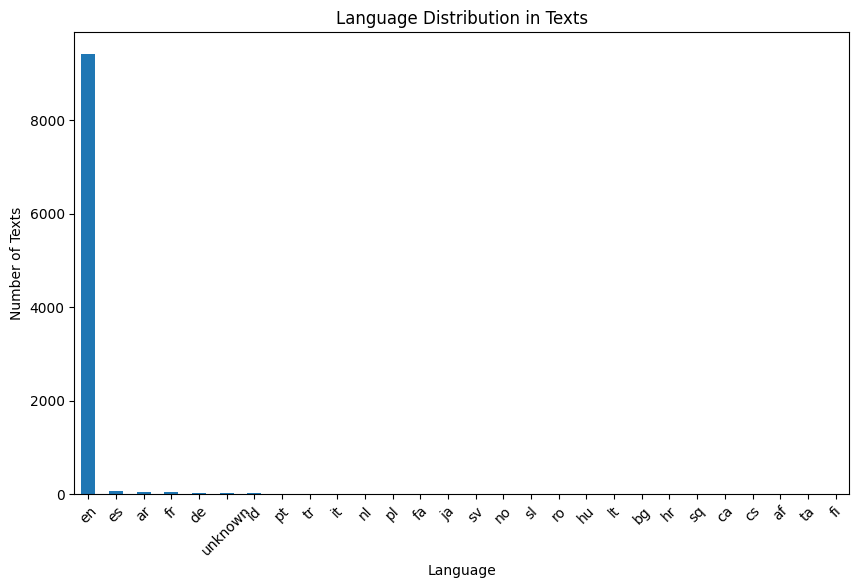

In [7]:
plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar')
plt.title('Language Distribution in Texts')
plt.xlabel('Language')
plt.ylabel('Number of Texts')
plt.xticks(rotation=45)
plt.show()

In [8]:
for column in data.columns:
    print(column + ': ' + str(len(data[data[column] == ''])))

book_id: 0
book_title: 0
isbn: 0
author: 0
num_pages: 0
description: 0
cover_image_uri: 0
series_length: 0
year_first_published: 0
average_rating: 0
rating_distribution: 0
tags: 0
language: 0


In [9]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    return text.strip()

In [10]:
old_desc = data['description'].copy()
data.loc[:, 'description'] = data.loc[:, 'description'].apply(clean_text)
print(f'Cleaned {(old_desc != data['description']).sum()} rows')

Cleaned 4833 rows


In [11]:
duplicates = data[data.duplicated(subset=['book_title', 'author'], keep=False)]
repeats = duplicates['book_title'].value_counts()
repeats

book_title
The Song of Achilles                 6
The Cheat Code                       6
The Oldest Dance                     5
The Seven Husbands of Evelyn Hugo    4
A Court of Mist and Fury             4
                                    ..
Kiss the Sky                         2
All That’s Left in the World         2
Fated to Love You                    2
The House on the Strand              2
Legends & Lattes                     2
Name: count, Length: 126, dtype: int64

In [12]:
duplicates_sorted = duplicates.sort_values(by=['book_title', 'author', 'book_id'])

In [13]:
def select_best_row(group):

    filtered_group = group[~group['description'].str.contains("Alternate cover", case=False, na=False)]

    if not filtered_group.empty:
        first_row = filtered_group.iloc[0].copy() 
    else:
        first_row = group.iloc[0].copy()

    if first_row['isbn'] == 'isbn not found':
        new_row = group.loc[group['isbn'] != 'isbn not found']
        if not new_row.empty:
            first_row['isbn'] = new_row.iloc[0]['isbn']

    if pd.isna(first_row['num_pages']):
        new_row = group.loc[group['isbn'].notna()]
        if not new_row.empty:
            first_row['num_pages'] = new_row.iloc[0]['num_pages']
    return first_row

In [14]:
filtered_df = duplicates_sorted.groupby(['book_title', 'author'], as_index=False).apply(select_best_row)

/tmp/ipykernel_17288/4216671159.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = duplicates_sorted.groupby(['book_title', 'author'], as_index=False).apply(select_best_row)


In [15]:
keep = duplicates_sorted[duplicates_sorted['book_id'].isin(filtered_df['book_id'])]
delete = duplicates_sorted[~duplicates_sorted['book_id'].isin(filtered_df['book_id'])]
print(len(keep))
print(len(delete))
print(len(duplicates_sorted))

126
164
290


In [16]:
data = data.drop(index=delete.index)
data.loc[keep.index] = keep

In [17]:
data = data.drop('language', axis=1)
data.to_csv('goodreads_scraper/books_cleaned.csv', index=False)